In [2]:

import os
import warnings
import logging
import tensorflow as tf

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print("All warnings are suppressed.")


All warnings are suppressed.


In [ ]:


import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Add GhostFaceNets source code
GHOSTFACENET_PATH = "/kaggle/input/ghostfacenet/GhostFaceNets"
sys.path.append(GHOSTFACENET_PATH)

import GhostFaceNets
import losses
import train
import evals

print("GhostFaceNets imported successfully.")


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GhostFaceNets imported successfully.


In [ ]:


# WebFace-112x112 (fine-tune)
WEBFACE_ROOT = "/kaggle/input/webface-112x112/webface_112x112"

# MS1M-ArcFace evaluation bins
MS1M_ROOT = "/kaggle/input/ms1m-arcface/faces_emore"

EVAL_BINS = {
    "LFW": os.path.join(MS1M_ROOT, "lfw.bin"),
    "CFP_FP": os.path.join(MS1M_ROOT, "cfp_fp.bin"),
    "AgeDB": os.path.join(MS1M_ROOT, "agedb_30.bin"),
    "CALFW": os.path.join(MS1M_ROOT, "calfw.bin"),
    "CPLFW": os.path.join(MS1M_ROOT, "cplfw.bin"),
}

# Pretrained GhostFaceNet weight
PRETRAINED_WEIGHT = "/kaggle/input/ghostfacenet-w1-3/GhostFaceNet_W1.3_S1_ArcFace.h5"

print("WebFace root:", WEBFACE_ROOT)
print("MS1M eval root:", MS1M_ROOT)
print("Pretrained model:", PRETRAINED_WEIGHT)

print("\nEvaluation sets:")
for k, v in EVAL_BINS.items():
    print(k, "->", v)


WebFace root: /kaggle/input/webface-112x112/webface_112x112
MS1M eval root: /kaggle/input/ms1m-arcface/faces_emore
Pretrained model: /kaggle/input/ghostfacenet-w1-3/GhostFaceNet_W1.3_S1_ArcFace.h5

Evaluation sets:
LFW -> /kaggle/input/ms1m-arcface/faces_emore/lfw.bin
CFP_FP -> /kaggle/input/ms1m-arcface/faces_emore/cfp_fp.bin
AgeDB -> /kaggle/input/ms1m-arcface/faces_emore/agedb_30.bin
CALFW -> /kaggle/input/ms1m-arcface/faces_emore/calfw.bin
CPLFW -> /kaggle/input/ms1m-arcface/faces_emore/cplfw.bin


Total identities: 10572
Min images per ID: 2
Max images per ID: 802
Mean images per ID: 46.4077752553916


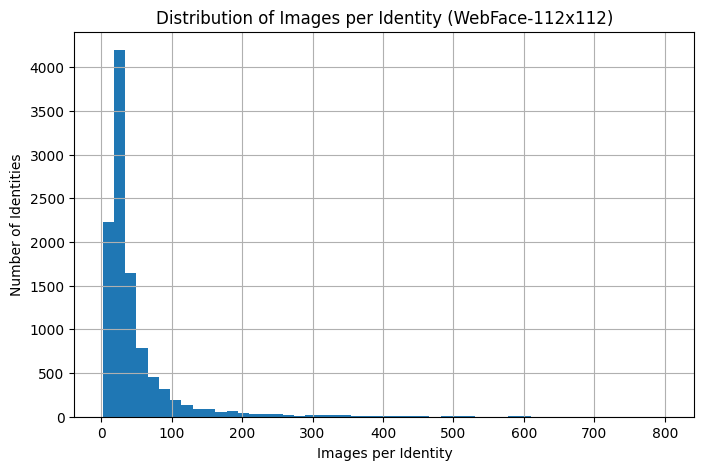

Identities with >= 5 images: 10569
Removed identities: 3


In [ ]:


identity_dirs = sorted(os.listdir(WEBFACE_ROOT))
num_ids = len(identity_dirs)

print("Total identities:", num_ids)

image_counts = []
for id_name in identity_dirs:
    img_dir = os.path.join(WEBFACE_ROOT, id_name)
    n_imgs = len(os.listdir(img_dir))
    image_counts.append(n_imgs)

image_counts = np.array(image_counts)

print("Min images per ID:", image_counts.min())
print("Max images per ID:", image_counts.max())
print("Mean images per ID:", image_counts.mean())

# Histogram
plt.figure(figsize=(8,5))
plt.hist(image_counts, bins=50)
plt.title("Distribution of Images per Identity (WebFace-112x112)")
plt.xlabel("Images per Identity")
plt.ylabel("Number of Identities")
plt.grid(True)
plt.show()

# Filter identities with too few images (e.g. < 5)
MIN_IMAGES = 5
valid_ids = [id_name for id_name, cnt in zip(identity_dirs, image_counts) if cnt >= MIN_IMAGES]

print(f"Identities with >= {MIN_IMAGES} images:", len(valid_ids))
print("Removed identities:", num_ids - len(valid_ids))


In [ ]:


IMG_SIZE = 112
BATCH_SIZE = 128

def preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - 0.5) * 2.0  # [-1,1] for ArcFace
    return img, label

def build_dataset(root, valid_ids):
    img_paths, labels = [], []
    id_to_label = {name: idx for idx, name in enumerate(valid_ids)}

    for id_name in valid_ids:
        folder = os.path.join(root, id_name)
        for f in os.listdir(folder):
            img_paths.append(os.path.join(folder, f))
            labels.append(id_to_label[id_name])

    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.shuffle(10000).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds, len(id_to_label)

train_ds, NUM_CLASSES = build_dataset(WEBFACE_ROOT, valid_ids)

print("Training samples:", len(train_ds) * BATCH_SIZE)
print("Number of identities (classes):", NUM_CLASSES)


I0000 00:00:1768658041.789429      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768658041.793203      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training samples: 490624
Number of identities (classes): 10569


In [9]:
basic_model = GhostFaceNets.buildin_models("ghostnetv1", dropout=0, emb_shape=512, output_layer='GDC', bn_momentum=0.9, bn_epsilon=1e-5)
basic_model = GhostFaceNets.add_l2_regularizer_2_model(basic_model, weight_decay=5e-4, apply_to_batch_normal=False)
basic_model = GhostFaceNets.replace_ReLU_with_PReLU(basic_model)

>>>> Change BatchNormalization momentum and epsilon default value.
>>>> Convert ReLU: activation --> activation
>>>> Convert ReLU: activation_1 --> activation_1
>>>> Convert ReLU: activation_2 --> activation_2
>>>> Convert ReLU: activation_3 --> activation_3
>>>> Convert ReLU: activation_4 --> activation_4
>>>> Convert ReLU: activation_5 --> activation_5
>>>> Convert ReLU: activation_6 --> activation_6
>>>> Convert ReLU: activation_7 --> activation_7
>>>> Convert ReLU: activation_8 --> activation_8
>>>> Convert ReLU: activation_9 --> activation_9
>>>> Convert ReLU: activation_11 --> activation_11
>>>> Convert ReLU: activation_12 --> activation_12
>>>> Convert ReLU: activation_13 --> activation_13
>>>> Convert ReLU: activation_15 --> activation_15
>>>> Convert ReLU: activation_16 --> activation_16
>>>> Convert ReLU: activation_17 --> activation_17
>>>> Convert ReLU: activation_18 --> activation_18
>>>> Convert ReLU: activation_19 --> activation_19
>>>> Convert ReLU: activation_20 --> ac

In [11]:
!pip install tf-keras

In [10]:
import tf_keras as keras

# Load model bằng tf_keras thay vì keras thông thường
basic_model = keras.models.load_model(PRETRAINED_WEIGHT, compile=False)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


I0000 00:00:1768675289.882796    1042 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768675289.886585    1042 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
basic_model.summary()

Model: "GhostNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 20)         540       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 20)         80        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (PReLU)          (None, 112, 112, 20)         20        ['batch_normalization[0

In [ ]:


import fileinput
import sys

evals_file = "/kaggle/input/ghostfacenet/GhostFaceNets/evals.py"

new_lines = []
with open(evals_file, "r") as f:
    for line in f:
        if "np.alltrue" in line:
            line = line.replace("np.alltrue", "np.all")
        new_lines.append(line)

patched_path = "/kaggle/working/evals_patched.py"
with open(patched_path, "w") as f:
    f.writelines(new_lines)

print("Patched evals.py saved to:", patched_path)

# Reload patched version
import importlib.util
spec = importlib.util.spec_from_file_location("evals_patched", patched_path)
evals = importlib.util.module_from_spec(spec)
spec.loader.exec_module(evals)

print("Reloaded patched evals module.")


Patched evals.py saved to: /kaggle/working/evals_patched.py
Reloaded patched evals module.


In [15]:
# Fix for NumPy 2.0: add back np.alltrue
import numpy as np
if not hasattr(np, "alltrue"):
    np.alltrue = np.all
print("np.alltrue patched.")


np.alltrue patched.


In [17]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

class eval_callback(keras.callbacks.Callback):
    def __init__(self, basic_model, test_bin_file, batch_size=256, PCA_acc=False, flip=True):
        super().__init__()
        self.model = basic_model
        self.batch_size = batch_size
        self.flip = flip
        self.PCA_acc = PCA_acc

        bins, self.issame_list = np.load(test_bin_file, allow_pickle=True)

        def gen():
            for b in bins:
                yield b

        ds = tf.data.Dataset.from_generator(
            gen,
            output_signature=tf.TensorSpec(shape=(), dtype=tf.string)
        )

        def _imread(xx):
            img = tf.image.decode_image(xx, channels=3)
            img = tf.image.resize(img, (112,112))
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) * 0.0078125
            return img

        ds = ds.map(_imread, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        self.ds = ds

    def on_epoch_end(self, epoch, logs=None):
        from evals import evaluate
        acc, thresh = evaluate(self.ds, self.issame_list, self.model, self.flip, self.PCA_acc)
        print(f">>>> Accuracy: {acc:.6f}, thresh: {thresh:.6f}")


In [28]:
import evals_patched as evals
print("==== Evaluate PRETRAINED on LFW ====")
ee_lfw_pre = evals.eval_callback(basic_model, EVAL_BINS["LFW"], batch_size=256, PCA_acc=False)
ee_lfw_pre.on_epoch_end(0)


==== Evaluate PRETRAINED on LFW ====



Evaluating lfw: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


>>>> lfw evaluation max accuracy: 0.997333, thresh: 0.268679, previous max accuracy: 0.000000
>>>> Improved = 0.997333


In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2, pickle, os
from sklearn.metrics.pairwise import cosine_similarity
def load_bin(path, image_size=(112,112)):
    with open(path, 'rb') as f:
        bins, issame_list = pickle.load(f, encoding='bytes')

    images = []
    for b in bins:
        img = cv2.imdecode(np.frombuffer(b, np.uint8), cv2.IMREAD_COLOR)
        img = cv2.resize(img, image_size)
        img = (img.astype(np.float32) - 127.5) / 128.0
        images.append(img)

    images = np.stack(images)
    return images, np.array(issame_list)


In [6]:
def get_embeddings(images, batch_size=256):
    emb = basic_model.predict(images, batch_size=batch_size, verbose=1)
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb


In [7]:
def evaluate_verification(embeddings, issame, thresholds=np.arange(-1, 1, 0.001)):
    sims = []
    labels = []

    for i in range(0, len(embeddings), 2):
        sim = cosine_similarity(
            embeddings[i].reshape(1,-1),
            embeddings[i+1].reshape(1,-1)
        )[0][0]
        sims.append(sim)
        labels.append(issame[i//2])

    sims = np.array(sims)
    labels = np.array(labels)

    best_acc, best_th = 0, 0
    for th in thresholds:
        preds = sims > th
        acc = np.mean(preds == labels)
        if acc > best_acc:
            best_acc = acc
            best_th = th

    return best_acc, best_th, sims, labels


In [8]:
EVAL_SETS = {
    "LFW": "/kaggle/input/ms1m-arcface/faces_emore/lfw.bin",
    "CFP_FP": "/kaggle/input/ms1m-arcface/faces_emore/cfp_fp.bin",
    "AgeDB": "/kaggle/input/ms1m-arcface/faces_emore/agedb_30.bin",
    #"CALFW": "/kaggle/input/ms1m-arcface/faces_emore/calfw.bin",
    #"CPLFW": "/kaggle/input/ms1m-arcface/faces_emore/cplfw.bin",
}

# results = {}

# for name, path in EVAL_SETS.items():
#     print(f"\n==== Evaluating {name} ====")
#     imgs, issame = load_bin(path)
#     emb = get_embeddings(imgs)
#     acc, th, sims, labels = evaluate_verification(emb, issame)
#     print(f"{name} Accuracy: {acc:.4f}, Best Threshold: {th:.3f}")
#     results[name] = (acc, th)


In [37]:
import matplotlib.pyplot as plt

def plot_cosine_hist(sims, labels, title):
    pos = sims[labels==1]
    neg = sims[labels==0]

    plt.hist(pos, bins=100, alpha=0.5, label="Same")
    plt.hist(neg, bins=100, alpha=0.5, label="Different")
    plt.title(title)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


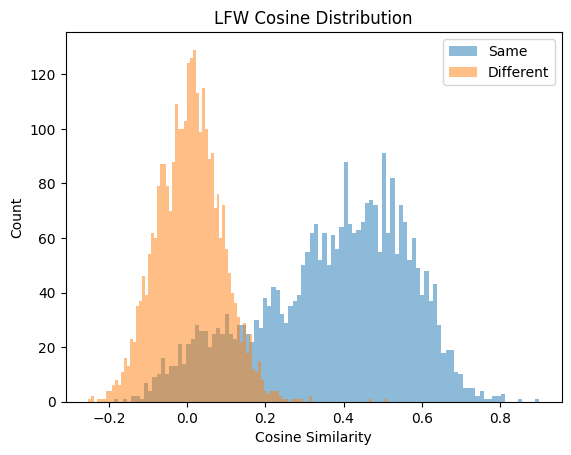

In [38]:
plot_cosine_hist(sims, labels, "LFW Cosine Distribution")


In [44]:
IMG_SIZE = 112
BATCH_SIZE = 128
EMB_SIZE = 512

BASE_LR = 1e-3 * (BATCH_SIZE / 512)   # Fine-tune LR nhỏ
FREEZE_EPOCHS = 3
UNFREEZE_EPOCHS = 7
TOTAL_EPOCHS = FREEZE_EPOCHS + UNFREEZE_EPOCHS

print("WebFace root:", WEBFACE_ROOT)
print("Pretrained model:", PRETRAINED_WEIGHT)
print("Base LR:", BASE_LR)
print("Total epochs:", TOTAL_EPOCHS)

WebFace root: /kaggle/input/webface-112x112/webface_112x112
Pretrained model: /kaggle/input/ghostfacenet-w1-3/GhostFaceNet_W1.3_S1_ArcFace.h5
Base LR: 0.00025
Total epochs: 10


In [39]:
# Freeze backbone
for layer in basic_model.layers:
    layer.trainable = False

print("Backbone frozen. Total layers:", len(basic_model.layers))

Backbone frozen. Total layers: 298


In [45]:
for l in basic_model.layers[-5:]:
    print(l.name, "trainable =", l.trainable)

batch_normalization_80 trainable = False
conv2d_53 trainable = False
flatten trainable = False
batch_normalization_81 trainable = False
embedding trainable = False


In [48]:
# if not hasattr(train.Train, "triplet"):
#     train.Train.triplet = "triplet"
# if not hasattr(train.Train, "center"):
#     train.Train.center = "center"
# if not hasattr(train.Train, "softmax"):
#     train.Train.softmax = "softmax"
# if not hasattr(train.Train, "arcface"):
#     train.Train.arcface = "arcface"

# print("Patched Train class attributes: triplet, center, softmax, arcface")


Patched Train class attributes: triplet, center, softmax, arcface


In [50]:
# optimizer = keras.optimizers.SGD(
#     learning_rate=BASE_LR,
#     momentum=0.9,
#     nesterov=True
# )

# tt = train.Train(
#     train_ds,
#     save_path="ghostfacenet_asian_phase1.h5",
#     basic_model=basic_model,
#     model=None,
#     lr_base=BASE_LR,
#     lr_decay=0.1,
#     lr_decay_steps=20,
#     batch_size=BATCH_SIZE,
#     random_status=0,
#     eval_freq=1,
#     output_weight_decay=5e-4
# )

# schedule_phase1 = [
#     {
#         "type": "arcface",
#         "loss": losses.ArcfaceLoss(scale=64, margin2=0.35),
#         "epoch": 2,
#         "optimizer": optimizer
#     },
#     {
#         "type": "arcface",
#         "loss": losses.ArcfaceLoss(scale=64, margin2=0.45),
#         "epoch": 1,
#         "optimizer": optimizer
#     }
# ]

# print("Start Phase 1: Train ArcFace head only (Backbone frozen)")
# tt.train(schedule_phase1, 0)


In [ ]:
# # =========================================================
# # CELL 5: Phase 2 Fine-tune (Unfreeze last blocks)
# # =========================================================

# # Unfreeze 20 layer cuối của backbone
# for layer in basic_model.layers[-20:]:
#     layer.trainable = True

# print("Trainable layers after unfreeze:",
#       sum([l.trainable for l in basic_model.layers]),
#       "/", len(basic_model.layers))

# # Giảm Learning Rate 10 lần so với Phase 1
# FINE_LR = BASE_LR * 0.1

# optimizer_finetune = keras.optimizers.SGD(
#     learning_rate=FINE_LR,
#     momentum=0.9,
#     nesterov=True
# )

# # Khởi tạo lại Trainer để tiếp tục train từ weight Phase 1
# tt2 = train.Train(
#     train_ds,
#     save_path="ghostfacenet_asian_final.h5",
#     basic_model=basic_model,
#     model=None,
#     lr_base=FINE_LR,
#     lr_decay=0.1,
#     lr_decay_steps=30,
#     batch_size=BATCH_SIZE,
#     random_status=0,
#     eval_freq=1,
#     output_weight_decay=5e-4
# )

# # Phase 2: Margin chuẩn ArcFace (0.5)
# schedule_phase2 = [
#     {
#         "loss": losses.ArcfaceLoss(scale=64, margin2=0.5),
#         "epoch": UNFREEZE_EPOCHS,   # ví dụ 7 epoch
#         "optimizer": optimizer_finetune
#     }
# ]

# print("Start Phase 2: Fine-tune last backbone blocks with ArcFace m=0.5")
# tt2.train(schedule_phase2, FREEZE_EPOCHS)

# print("Phase 2 finished. Final model saved: ghostfacenet_asian_final.h5")


In [81]:
class ArcFaceModel(tf.keras.Model):
    def __init__(self, backbone, num_classes, s=64.0, m=0.5):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.s = s
        self.m = m
        
        # Class weights
        self.W = self.add_weight(
            shape=(num_classes, EMB_SIZE),
            initializer="glorot_uniform",
            trainable=True,
            name="arcface_kernel"
        )

    def call(self, images, labels, training=True):
        embeddings = self.backbone(images, training=training)
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)

        W = tf.nn.l2_normalize(self.W, axis=1)

        logits = tf.matmul(embeddings, W, transpose_b=True)
        logits = tf.clip_by_value(logits, -1.0 + 1e-7, 1.0 - 1e-7)

        theta = tf.acos(logits)
        target_logits = tf.cos(theta + self.m)

        one_hot = tf.one_hot(labels, depth=self.num_classes)
        output = logits * (1.0 - one_hot) + target_logits * one_hot
        output *= self.s
        return output, embeddings


In [82]:
class AdaFaceModel(tf.keras.Model):
    def __init__(self, backbone, num_classes, s=64.0, m=0.4, h=0.333, eps=1e-3):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.h = h
        self.eps = eps

        self.W = self.add_weight(
            shape=(num_classes, 512),
            initializer="glorot_uniform",
            trainable=True,
            name="adaface_kernel"
        )

        # running statistics of feature norm
        self.t = tf.Variable(0.0, trainable=False)
        self.running_mean = tf.Variable(20.0, trainable=False)
        self.running_std = tf.Variable(100.0, trainable=False)

    def call(self, images, labels, training=True):
        embeddings = self.backbone(images, training=training)
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)

        W = tf.nn.l2_normalize(self.W, axis=1)
        cosine = tf.matmul(embeddings, W, transpose_b=True)
        cosine = tf.clip_by_value(cosine, -1 + self.eps, 1 - self.eps)

        # feature norm
        norm = tf.norm(embeddings, axis=1, keepdims=True)

        if training:
            batch_mean = tf.reduce_mean(norm)
            batch_std = tf.math.reduce_std(norm)
            self.running_mean.assign(0.99 * self.running_mean + 0.01 * batch_mean)
            self.running_std.assign(0.99 * self.running_std + 0.01 * batch_std)

        normed = (norm - self.running_mean) / (self.running_std + self.eps)
        margin = self.m * (1 + self.h * tf.clip_by_value(normed, -1, 1))

        theta = tf.acos(cosine)
        target_logits = tf.cos(theta + margin)

        one_hot = tf.one_hot(labels, depth=self.num_classes)
        output = cosine * (1 - one_hot) + target_logits * one_hot
        output *= self.s

        return output, embeddings


In [85]:
# Freeze backbone
for layer in basic_model.layers:
    layer.trainable = False

adaface_model = AdaFaceModel(
    backbone=basic_model,
    num_classes=NUM_CLASSES,
    s=64.0,
    m=0.4,
    h=0.333,
    eps=1e-3
)

BASE_LR = 1e-3 * (BATCH_SIZE / 512)
optimizer = tf.keras.optimizers.SGD(
    learning_rate=BASE_LR,
    momentum=0.9,
    nesterov=True
)

ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits, _ = adaface_model(images, labels, training=True)
        loss = ce_loss(labels, logits)
    grads = tape.gradient(loss, adaface_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, adaface_model.trainable_variables))
    return loss

EPOCHS_PHASE1 = 4
for epoch in range(EPOCHS_PHASE1):
    total_loss = 0
    steps = 0
    for images, labels in train_ds:
        loss = train_step(images, labels)
        total_loss += loss
        steps += 1
    print(f"Phase1 Epoch [{epoch+1}/{EPOCHS_PHASE1}] - Loss: {total_loss/steps:.4f}")

# Save full model (an toàn nhất, load lại không lỗi shape)
adaface_model.save("adaface_phase1.keras")
print("Saved: adaface_phase1.keras")


Phase1 Epoch [1/4] - Loss: 25.3700
Phase1 Epoch [2/4] - Loss: 14.9682
Phase1 Epoch [3/4] - Loss: 10.6961
Phase1 Epoch [4/4] - Loss: 8.2733
Saved: adaface_phase1.keras


In [86]:
# Chỉ save backbone (embedding model)
adaface_model.backbone.save("ghostfacenet_asian_backbone.keras")
print("Saved: ghostfacenet_asian_backbone.keras")


Saved: ghostfacenet_asian_backbone.keras


In [87]:
# Unfreeze last 30 layers
for layer in basic_model.layers[-30:]:
    layer.trainable = True
print("Unfrozen last 30 layers")

FINE_LR = BASE_LR * 0.1
optimizer = tf.keras.optimizers.SGD(
    learning_rate=FINE_LR,
    momentum=0.9,
    nesterov=True
)

@tf.function
def train_step_finetune(images, labels):
    with tf.GradientTape() as tape:
        logits, _ = adaface_model(images, labels, training=True)
        loss = ce_loss(labels, logits)
    grads = tape.gradient(loss, adaface_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, adaface_model.trainable_variables))
    return loss

EPOCHS_PHASE2 = 6
for epoch in range(EPOCHS_PHASE2):
    total_loss = 0
    steps = 0
    for images, labels in train_ds:
        loss = train_step_finetune(images, labels)
        total_loss += loss
        steps += 1
    print(f"Phase2 Epoch [{epoch+1}/{EPOCHS_PHASE2}] - Loss: {total_loss/steps:.4f}")

# Save full fine-tuned model
adaface_model.save("adaface_asian_finetuned.keras")
print("Saved: adaface_asian_finetuned.keras")


Unfrozen last 30 layers
Phase2 Epoch [1/6] - Loss: 7.9799
Phase2 Epoch [2/6] - Loss: 7.7640
Phase2 Epoch [3/6] - Loss: 7.5756
Phase2 Epoch [4/6] - Loss: 7.4074
Phase2 Epoch [5/6] - Loss: 7.2550
Phase2 Epoch [6/6] - Loss: 7.1165
Saved: adaface_asian_finetuned.keras


In [88]:
# Save backbone only (chuẩn cho cosine + ROC)
adaface_model.backbone.save("ghostfacenet_asian_adaface_backbone.keras")
print("Saved: ghostfacenet_asian_adaface_backbone.keras")


Saved: ghostfacenet_asian_adaface_backbone1.keras


In [78]:
arcface_model.backbone.save("ghostfacenet_backbone_asian_finetuned.keras")


In [96]:
import tf_keras as keras

backbone1 = keras.models.load_model(
    "ghostfacenet_backbone_asian_finetuned.keras",
    compile=False
)

backbone1.summary()


Model: "GhostNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 20)         540       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 20)         80        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (PReLU)          (None, 112, 112, 20)         20        ['batch_normalization[0

In [12]:
import tf_keras as keras

backbone1 = keras.models.load_model(
    "ghostfacenet_asian_adaface_backbone.keras",
    compile=False
)

print("Loaded AdaFace fine-tuned backbone OK")
backbone1.summary()


Loaded AdaFace fine-tuned backbone OK
Model: "GhostNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 20)         540       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 20)         80        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (PReLU)          (None, 112, 112, 20)    

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def get_embeddings(model, imgs, batch_size=128):
    embs = model.predict(imgs, batch_size=batch_size, verbose=1)
    embs = embs / np.linalg.norm(embs, axis=1, keepdims=True)
    return embs
results_before = {}
results_after = {}


print("\n========== EVALUATE PRETRAINED MODEL ==========")

for name, path in EVAL_SETS.items():
    print(f"\n---- {name} ----")
    imgs, issame = load_bin(path)
    emb = get_embeddings(basic_model, imgs)
    acc, th, sims, labels = evaluate_verification(emb, issame)
    print(f"{name} Accuracy (Pretrained): {acc:.4f}, Threshold: {th:.3f}")
    results_before[name] = acc


print("\n========== EVALUATE FINE-TUNED ASIAN MODEL ==========")

for name, path in EVAL_SETS.items():
    print(f"\n---- {name} ----")
    imgs, issame = load_bin(path)
    emb = get_embeddings(backbone1, imgs)
    acc, th, sims, labels = evaluate_verification(emb, issame)
    print(f"{name} Accuracy (Fine-tuned): {acc:.4f}, Threshold: {th:.3f}")
    results_after[name] = acc


print("\n========== COMPARISON ==========")
for name in EVAL_SETS.keys():
    before = results_before[name]
    after = results_after[name]
    delta = after - before
    print(f"{name:8s}: {before:.4f} → {after:.4f}  (Δ = {delta:+.4f})")



========== EVALUATE PRETRAINED MODEL ==========

---- LFW ----


I0000 00:00:1768675361.982346    1080 cuda_dnn.cc:529] Loaded cuDNN version 91002


94/94 [==============================] - 73s 418ms/step
LFW Accuracy (Pretrained): 0.9960, Threshold: 0.237

---- CFP_FP ----
110/110 [==============================] - 41s 372ms/step
CFP_FP Accuracy (Pretrained): 0.9536, Threshold: 0.140

---- AgeDB ----
94/94 [==============================] - 11s 114ms/step
AgeDB Accuracy (Pretrained): 0.9737, Threshold: 0.207

========== EVALUATE FINE-TUNED ASIAN MODEL ==========

---- LFW ----
94/94 [==============================] - 13s 115ms/step
LFW Accuracy (Fine-tuned): 0.9952, Threshold: 0.240

---- CFP_FP ----
110/110 [==============================] - 13s 116ms/step
CFP_FP Accuracy (Fine-tuned): 0.9513, Threshold: 0.142

---- AgeDB ----
94/94 [==============================] - 11s 117ms/step
AgeDB Accuracy (Fine-tuned): 0.9752, Threshold: 0.212

========== COMPARISON ==========
LFW     : 0.9960 → 0.9952  (Δ = -0.0008)
CFP_FP  : 0.9536 → 0.9513  (Δ = -0.0023)
AgeDB   : 0.9737 → 0.9752  (Δ = +0.0015)


In [15]:
import os
import random
import itertools

def create_vn_celeb_pairs(data_dir, num_pairs=1000):
    ids = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    pos_pairs = []
    neg_pairs = []

    print("Generating pairs from VN-Celeb...")
    
    # 1. Tạo cặp Positive (cùng ID)
    for _ in range(num_pairs // 2):
        chosen_id = random.choice(ids)
        id_path = os.path.join(data_dir, chosen_id)
        imgs = os.listdir(id_path)
        if len(imgs) >= 2:
            img1, img2 = random.sample(imgs, 2)
            pos_pairs.append((os.path.join(id_path, img1), os.path.join(id_path, img2), True))
    
    # 2. Tạo cặp Negative (khác ID)
    for _ in range(num_pairs // 2):
        id1, id2 = random.sample(ids, 2)
        img1 = random.choice(os.listdir(os.path.join(data_dir, id1)))
        img2 = random.choice(os.listdir(os.path.join(data_dir, id2)))
        neg_pairs.append((os.path.join(data_dir, id1, img1), os.path.join(data_dir, id2, img2), False))

    all_pairs = pos_pairs + neg_pairs
    random.shuffle(all_pairs)
    return all_pairs

def load_vn_celeb_images(pairs, image_size=(112, 112)):
    images = []
    issame_list = []
    for img1_path, img2_path, issame in pairs:
        for p in [img1_path, img2_path]:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            img = (img.astype(np.float32) - 127.5) / 128.0
            images.append(img)
        issame_list.append(issame)
    
    return np.stack(images), np.array(issame_list)

In [16]:

VN_CELEB_PATH = "/kaggle/input/vn-celeb/VN-celeb" 

print("\n========== EVALUATING ON VN-CELEB ==========")

pairs = create_vn_celeb_pairs(VN_CELEB_PATH, num_pairs=2000)
vn_imgs, vn_issame = load_vn_celeb_images(pairs)


print("\n[VN-Celeb] Evaluating Pretrained...")
emb_before = get_embeddings(basic_model, vn_imgs)
acc_before, th_before, _, _ = evaluate_verification(emb_before, vn_issame)

print("\n[VN-Celeb] Evaluating Fine-tuned...")
emb_after = get_embeddings(backbone1, vn_imgs)
acc_after, th_after, _, _ = evaluate_verification(emb_after, vn_issame)


delta = acc_after - acc_before
print("\n" + "="*30)
print(f"VN-CELEB RESULTS:")
print(f"Pretrained Accuracy : {acc_before:.4f} (Threshold: {th_before:.3f})")
print(f"Fine-tuned Accuracy  : {acc_after:.4f} (Threshold: {th_after:.3f})")
print(f"Improvement (Delta) : {delta:+.4f}")
print("="*30)


========== EVALUATING ON VN-CELEB ==========
Generating pairs from VN-Celeb...

[VN-Celeb] Evaluating Pretrained...
32/32 [==============================] - 32s 1s/step

[VN-Celeb] Evaluating Fine-tuned...
32/32 [==============================] - 4s 114ms/step

VN-CELEB RESULTS:
Pretrained Accuracy : 0.7865 (Threshold: 0.140)
Fine-tuned Accuracy  : 0.7990 (Threshold: 0.174)
Improvement (Delta) : +0.0125
